In [1]:
import pandas as pd
import numpy as np
import os

import keras
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Input

from sklearn.model_selection import train_test_split
import cv2 
import tensorflow as tf
import imageio
import matplotlib.pyplot as plt 
%matplotlib inline
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, Adamax

In [2]:
path = ''
image_lst = []
mask_lst = []
for j in range (0, 4):
    path_img = '/kaggle/input/brain-tumor-segmentation-dataset/Brain Tumor Segmentation Dataset/image/' + str(j) + '/'
    path_mask = '/kaggle/input/brain-tumor-segmentation-dataset/Brain Tumor Segmentation Dataset/mask/' + str(j) + '/'
    image_path = os.path.join(path, path_img)
    mask_path = os.path.join(path, path_mask)
    image_list = np.sort(os.listdir(image_path))
    mask_list = np.sort(os.listdir(mask_path))
    image_lst += [image_path+image_list[i] for i in range (len(image_list))]
    mask_lst += [mask_path+mask_list[i] for i in range (len(mask_list))]
    # Tr-gl_0899_m (1)
    # Tr-me_0540 (2)
mask_lst.remove("/kaggle/input/brain-tumor-segmentation-dataset/Brain Tumor Segmentation Dataset/mask/1/Tr-gl_0899_m.jpg")
mask_lst.remove("/kaggle/input/brain-tumor-segmentation-dataset/Brain Tumor Segmentation Dataset/mask/2/Tr-me_0540.jpg")

In [3]:
X=np.zeros((len(image_lst),256,256,3), dtype=np.float32)
y=np.zeros((len(mask_lst),256,256,1), dtype=np.int32)

for i in range(len(mask_lst)):
    img=cv2.imread(image_lst[i])
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(256,256))
    X[i] = img/255
    mask=cv2.imread(mask_lst[i],cv2.IMREAD_GRAYSCALE)
    mask=cv2.resize(mask,(256,256))
    mask = tf.one_hot(mask, 1, dtype=tf.int32)
    y[i] = mask
image = X
mask = y

In [4]:
X_train,X_test,y_train,y_test = train_test_split(image,mask,test_size=0.2,random_state=101)

In [5]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):

    conv = Conv2D(n_filters,
                  3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters,
                  3,  
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
    if max_pooling:
        next_layer = MaxPooling2D(2,strides=2)(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [6]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(
                 n_filters,
                 3,
                 strides=2,
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    
    return conv

In [7]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=1):

    inputs = Input(input_size)

    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8,dropout_prob=0.3)
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.3, max_pooling=False)
    

    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same', activation='sigmoid')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [8]:
model = unet_model(input_size=(256, 256, 3), n_classes=1)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_9[0][0]  

 Total params: 8,639,745 (32.96 MB)

 Trainable params: 8,639,745 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
smooth=1.

def dice_coef(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

def iou(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [10]:
model.compile(optimizer = tf.keras.optimizers.Adam(), loss=bce_dice_loss, metrics=['accuracy', iou, dice_coef])

In [11]:
history = model.fit(X_train, y_train, epochs=20, validation_split=0.1)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:674: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
I0000 00:00:1728362925.213640      95 service.cc:145] XLA service 0x7d2e00110ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728362925.213783      95 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1728362955.380633      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


96/96 ━━━━━━━━━━━━━━━━━━━━ 85s 512ms/step - accuracy: 0.9498 - dice_coef: 0.9512 - iou: 0.9183 - loss: 0.2173 - val_accuracy: 0.9863 - val_dice_coef: 0.9889 - val_iou: 0.9781 - val_loss: 0.0679
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 27s 286ms/step - accuracy: 0.9872 - dice_coef: 0.9902 - iou: 0.9805 - loss: 0.0562 - val_accuracy: 0.9863 - val_dice_coef: 0.9894 - val_iou: 0.9791 - val_loss: 0.0543
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 27s 286ms/step - accuracy: 0.9870 - dice_coef: 0.9908 - iou: 0.9818 - loss: 0.0495 - val_accuracy: 0.9863 - val_dice_coef: 0.9891 - val_iou: 0.9785 - val_loss: 0.0498
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 27s 286ms/step - accuracy: 0.9873 - dice_coef: 0.9919 - iou: 0.9840 - loss: 0.0413 - val_accuracy: 0.9898 - val_dice_coef: 0.9902 - val_iou: 0.9806 - val_loss: 0.0433
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 27s 285ms/step - accuracy: 0.9910 - dice_coef: 0.9928 - iou: 0.9858 - loss: 0.0371 - val_accuracy: 0.9911 - val_dice_coef: 0.9915 - val_iou: 0.9832 - val

In [12]:
model.evaluate(X_test, y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 300ms/step - accuracy: 0.9970 - dice_coef: 0.9982 - iou: 0.9963 - loss: 0.0133


[0.012792929075658321,
 0.9970721006393433,
 0.9964462518692017,
 0.9982195496559143]

In [13]:
y_pred = model.predict(X_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step


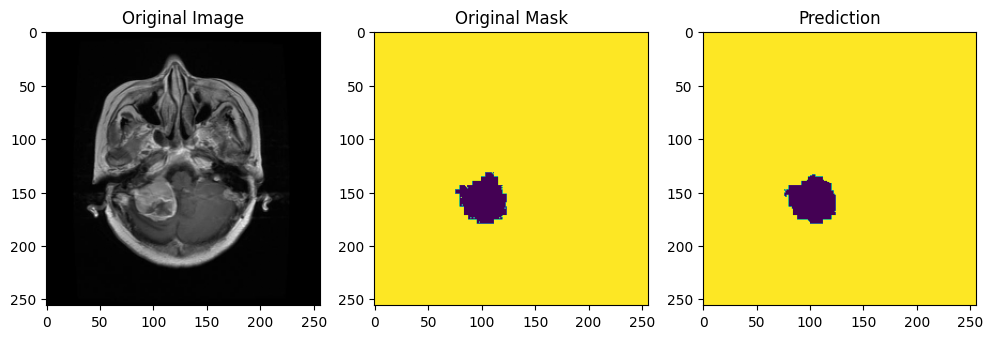

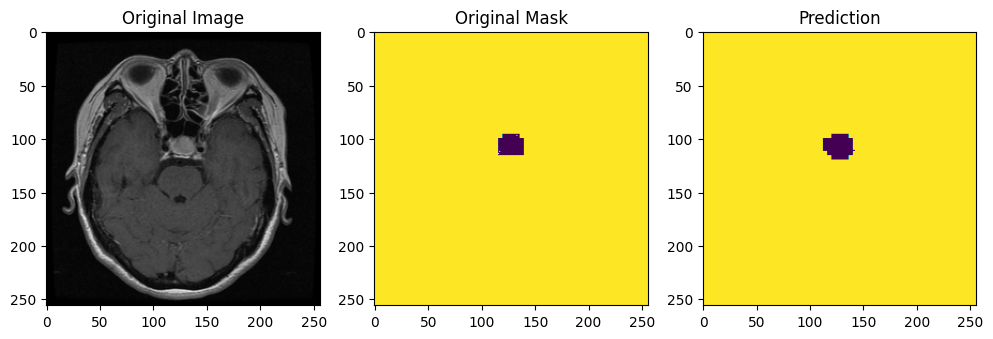

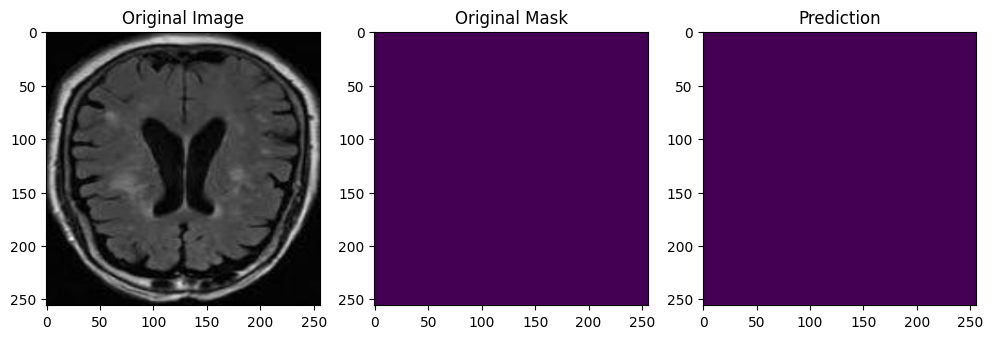

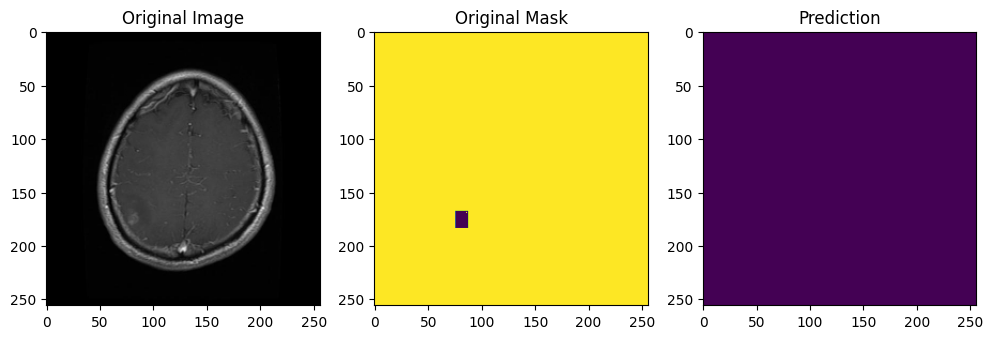

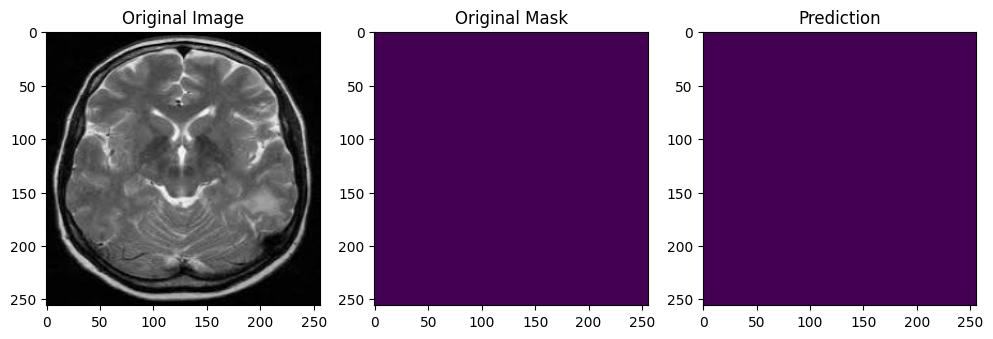

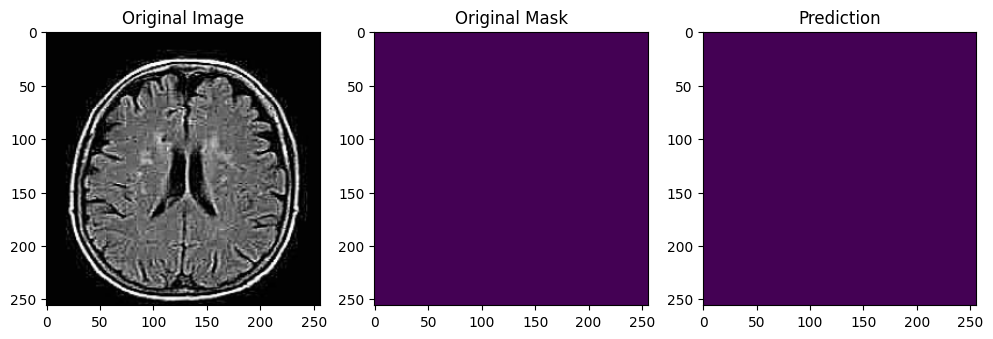

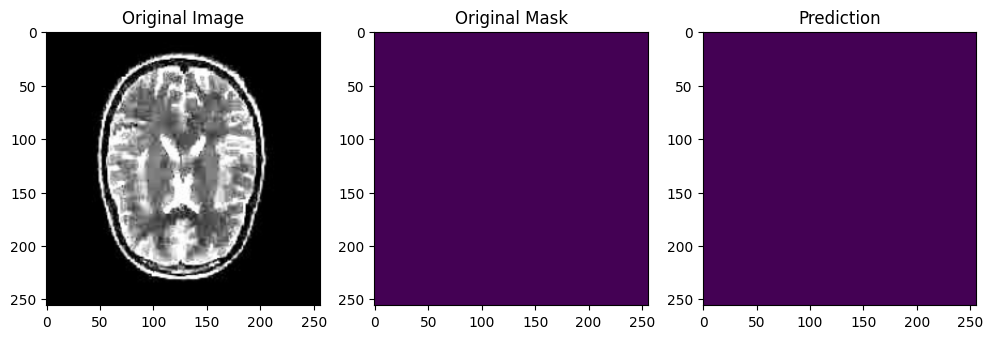

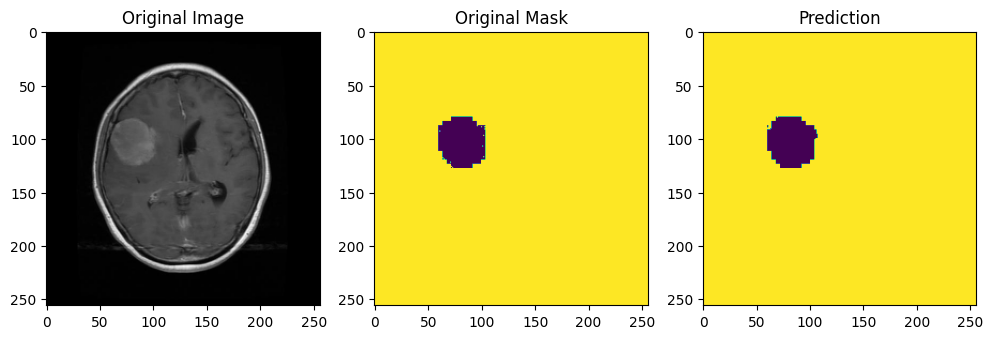

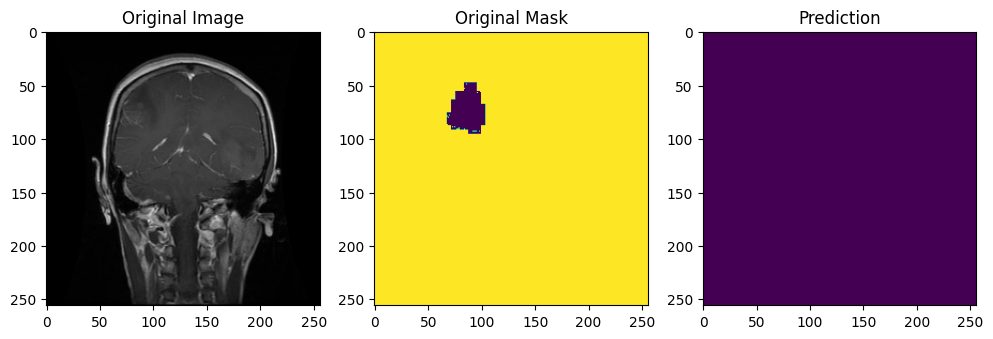

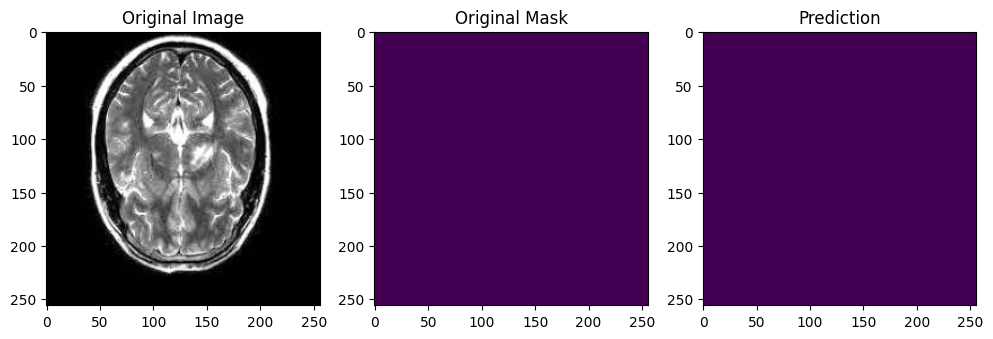

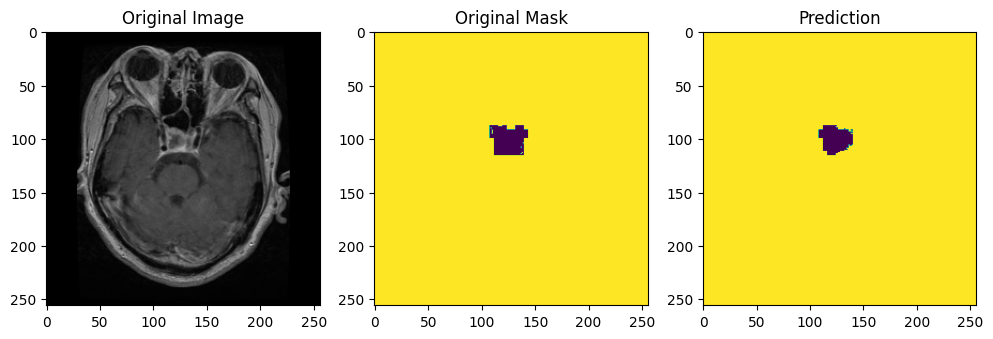

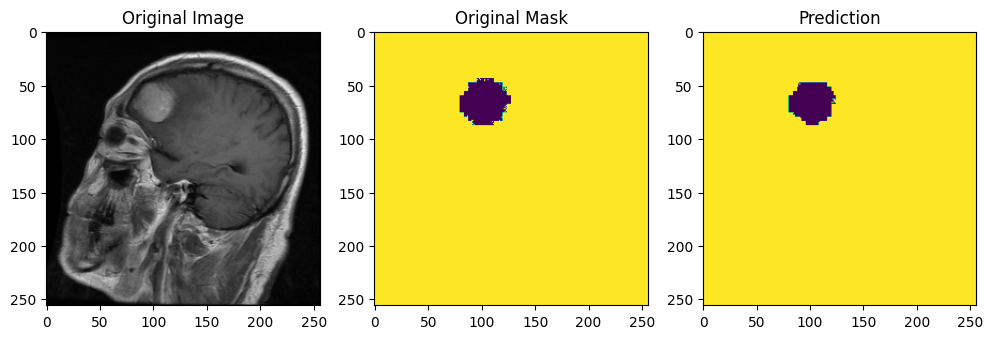

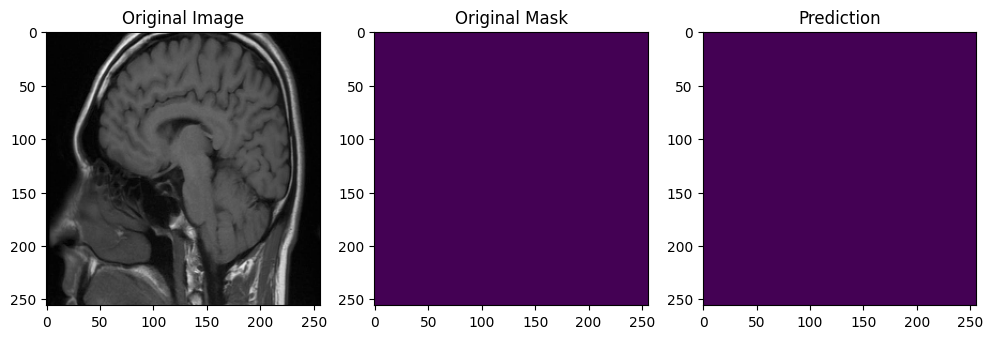

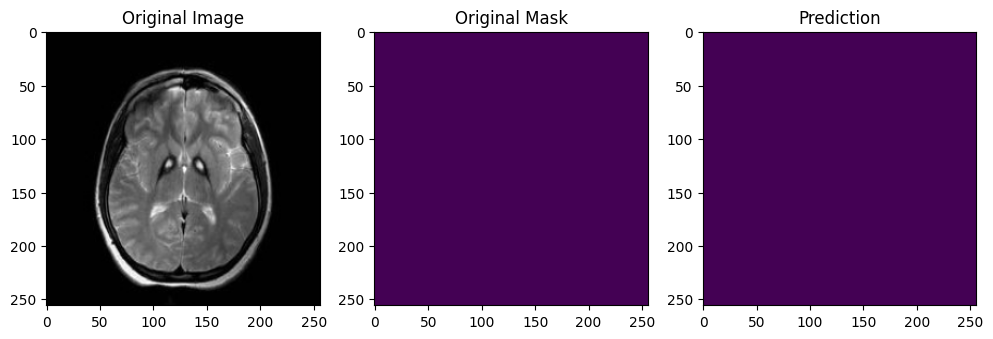

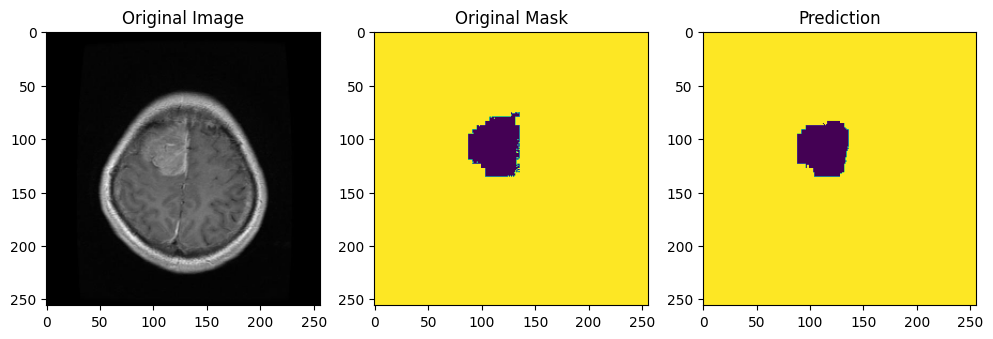

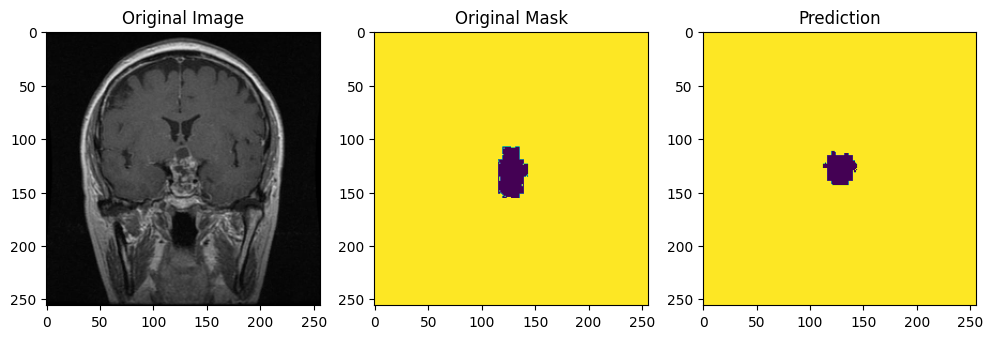

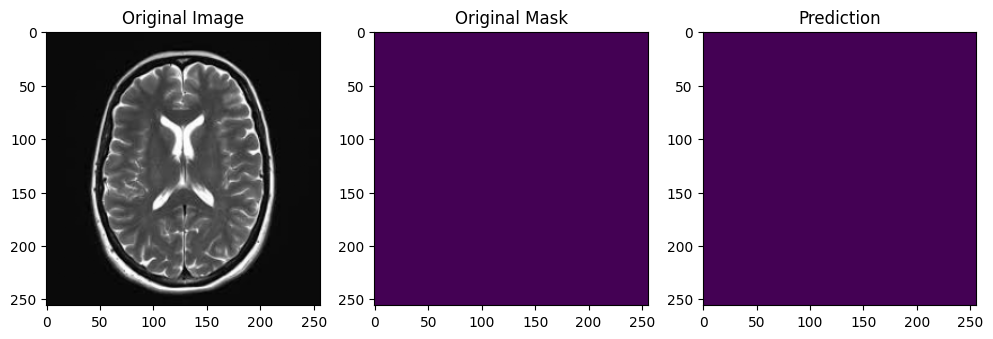

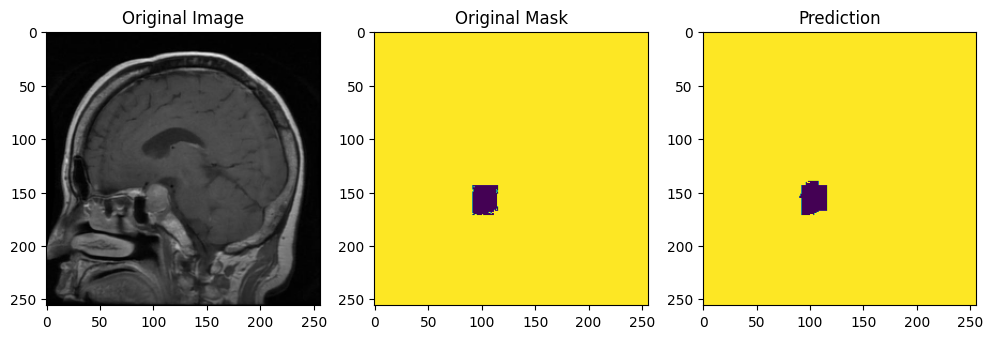

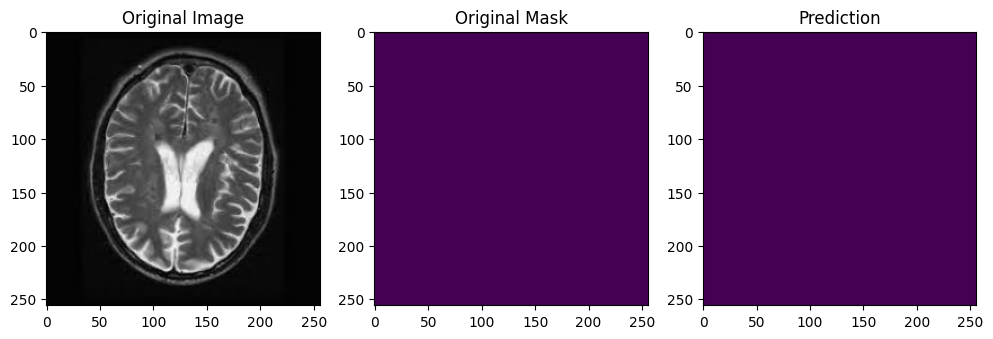

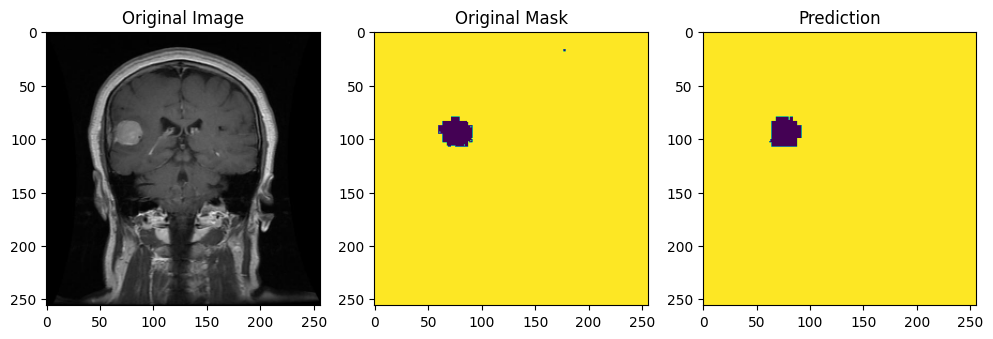

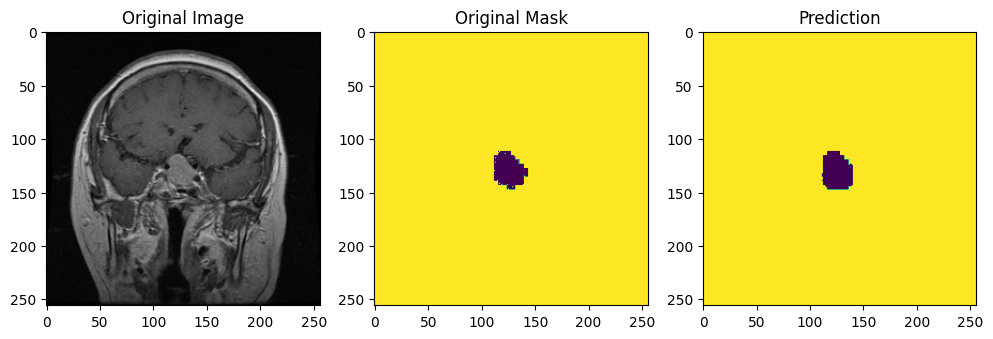

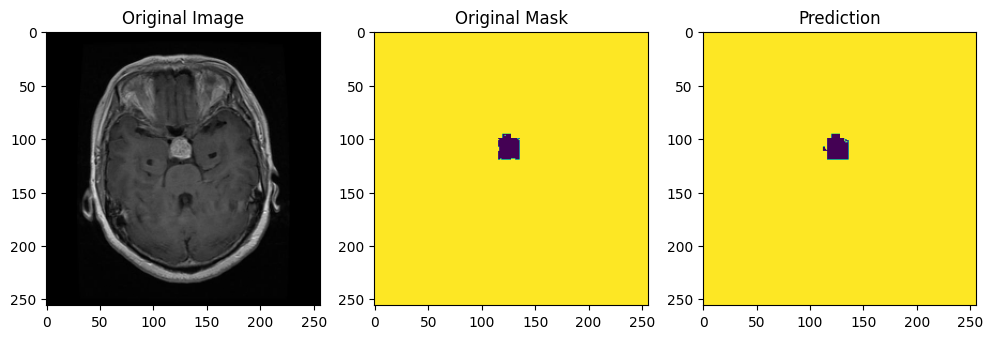

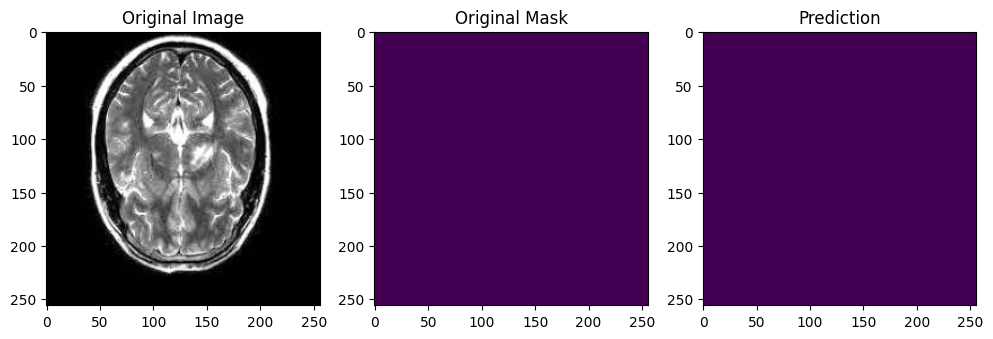

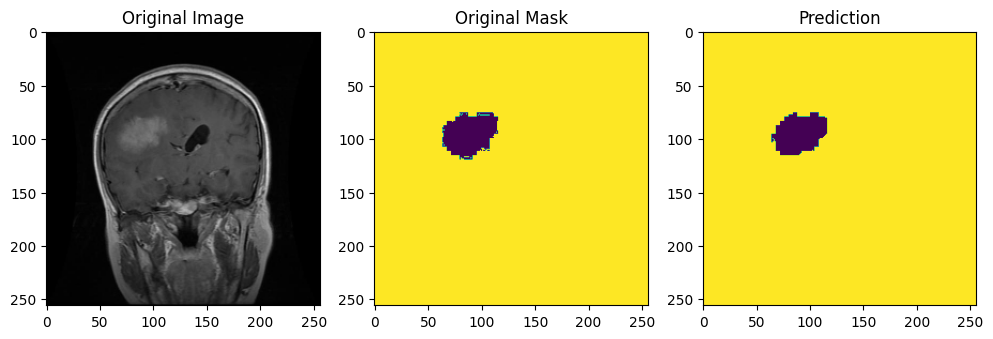

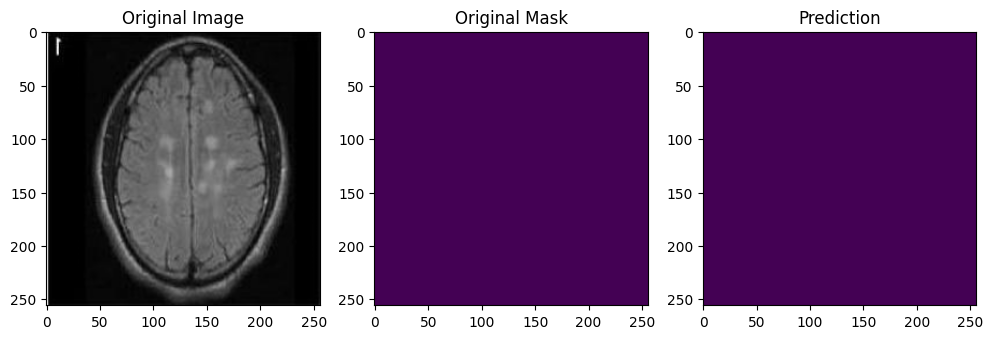

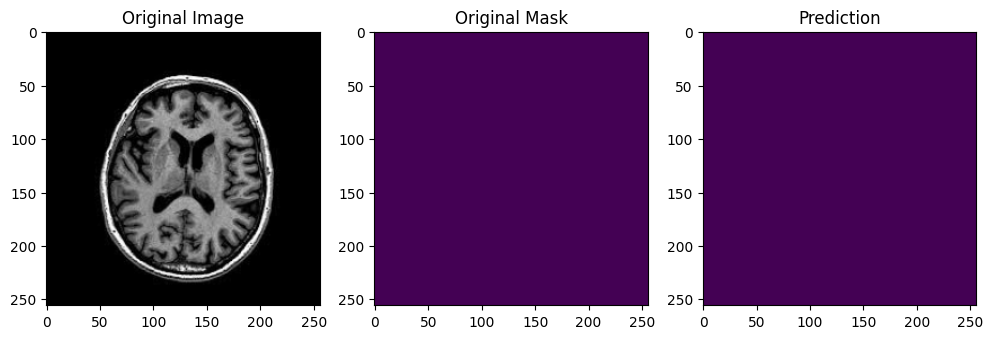

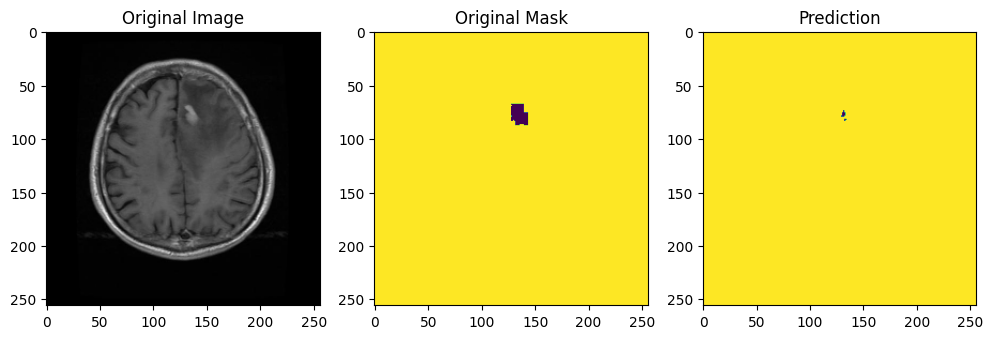

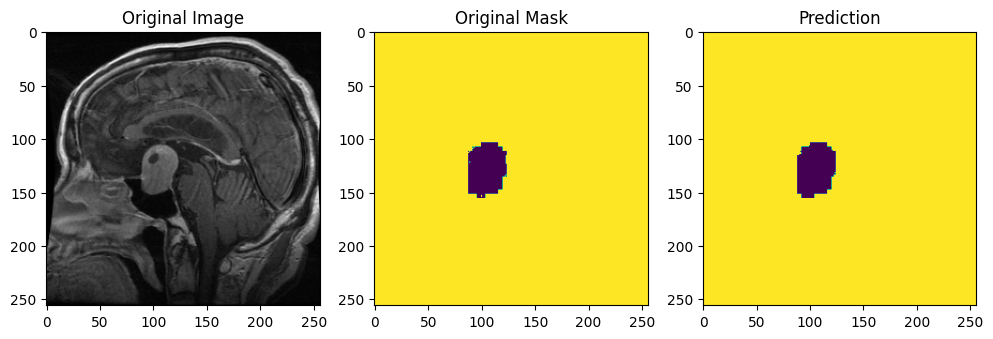

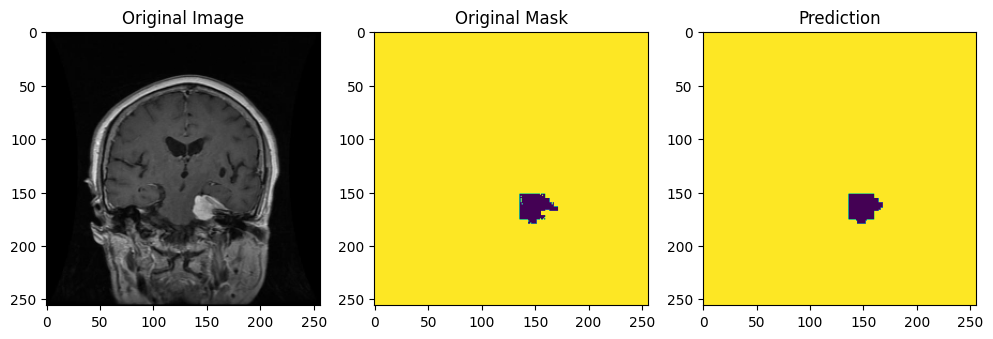

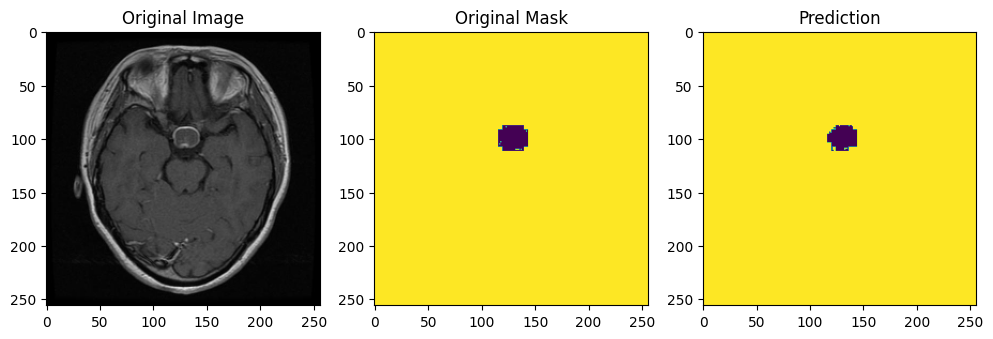

In [14]:
for i in range(30):
    index=np.random.randint(1,len(X_test))
    img = X_test[index]
    pred=y_pred[index]

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(y_test[index]))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

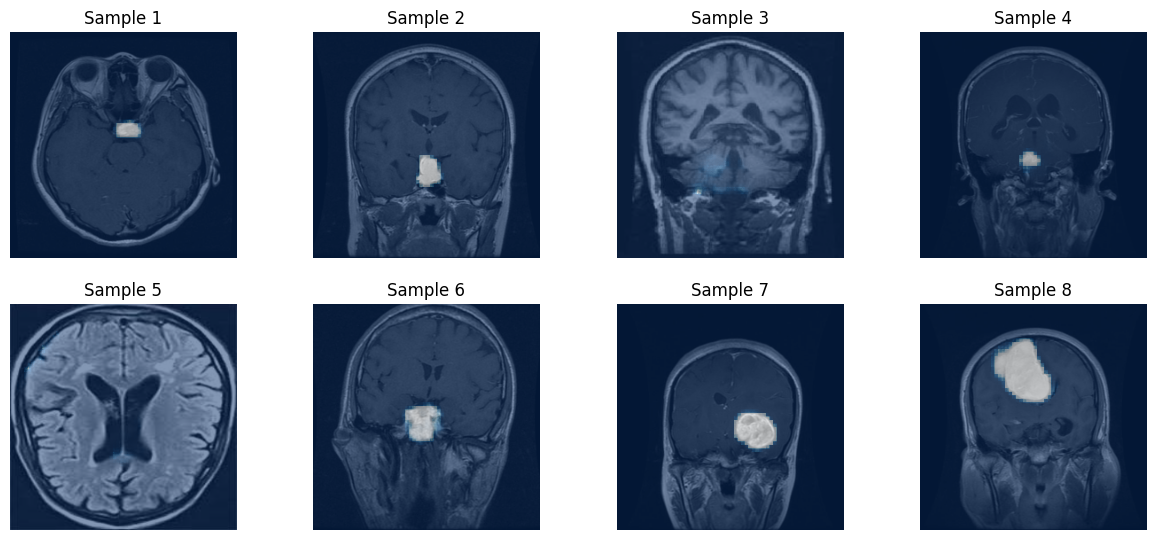

In [78]:
plt.figure(figsize=(15,10))

i = np.random.randint(1, len(X_test))-8
alpha = 0.5

plt.subplot(341)
plt.title('Sample 1')
plt.axis('off')
plt.imshow(np.squeeze(X_test[i,:,:]),cmap='gray')
plt.imshow(np.squeeze(y_pred[i,:,:]),alpha=alpha,cmap='Blues')

plt.subplot(342)
plt.title('Sample 2')
plt.axis('off')
plt.imshow(np.squeeze(X_test[i+1,:,:]),cmap='gray')
plt.imshow(np.squeeze(y_pred[i+1,:,:]),alpha=alpha,cmap='Blues')

plt.subplot(343)
plt.title('Sample 3')
plt.axis('off')
plt.imshow(np.squeeze(X_test[i+2,:,:]),cmap='gray')
plt.imshow(np.squeeze(y_pred[i+2,:,:]),alpha=alpha,cmap='Blues')

plt.subplot(344)
plt.title('Sample 4')
plt.axis('off')
plt.imshow(np.squeeze(X_test[i+3,:,:]),cmap='gray')
plt.imshow(np.squeeze(y_pred[i+3,:,:]),alpha=alpha,cmap='Blues')

plt.subplot(345)
plt.title('Sample 5')
plt.axis('off')
plt.imshow(np.squeeze(X_test[i+4,:,:]),cmap='gray')
plt.imshow(np.squeeze(y_pred[i+4,:,:]),alpha=alpha,cmap='Blues')

plt.subplot(346)
plt.title('Sample 6')
plt.axis('off')
plt.imshow(np.squeeze(X_test[i+5,:,:]),cmap='gray')
plt.imshow(np.squeeze(y_pred[i+5,:,:]),alpha=alpha,cmap='Blues')

plt.subplot(347)
plt.title('Sample 7')
plt.axis('off')
plt.imshow(np.squeeze(X_test[i+6,:,:]),cmap='gray')
plt.imshow(np.squeeze(y_pred[i+6,:,:]),alpha=alpha,cmap='Blues')

plt.subplot(348)
plt.title('Sample 8')
plt.axis('off')
plt.imshow(np.squeeze(X_test[i+7,:,:]),cmap='gray')
plt.imshow(np.squeeze(y_pred[i+7,:,:]),alpha=alpha,cmap='Blues')

In [80]:
model.save('Unet_tumor.h5')